# Modeling and Evaluation
**Flow of this section**
1. Establish baseline score with mean.
2. Fit features into linear regression
    - without standard scaling
    - with standard scaling
3. Fit lasso/ridge/elastic net 
    - with default parameters.
    - with tuned hyperparameters
4. Evaluate model for fine-tuning
    - remove features that are not significant
    - remove features that have multicollinearity 
6. Identify and submit a production model

## Modelling

In this section, I will explore a few models and evaluate its metrics.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import train_test_split.
from sklearn.model_selection import train_test_split

# Import logistic regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# read in data
df = pd.read_csv('./datasets/preprocessed_train_data.csv')
df_pred = pd.read_csv('./datasets/preprocessed_test_data.csv')

In [3]:
df.shape

(150634, 39)

In [4]:
df_pred.shape # roughly 10% of train data

(16737, 39)

In [5]:
df.head() # resale price is already transformed to log in preprocessing

flat_type  floor_area_sqm  lease_commence_date  resale_price  Tranc_Year  \
0          0            90.0                 2006     13.429848        2016   
1          1           130.0                 1987     13.407542        2012   
2          2           144.0                 1997     13.638773        2013   
3          0           103.0                 1992     13.217674        2012   
4          0            83.0                 1987     12.604849        2017   

   Tranc_Month  mid  hdb_age  year_completed  commercial  ...  model_Model A  \
0            5   11       15            2005           0  ...              1   
1            7    8       34            1987           0  ...              0   
2            7   14       24            1996           0  ...              0   
3            4    3       29            1990           1  ...              1   
4           12    2       34            1987           0  ...              1   

   model_Model A-Maisonette  model_Multi Generation  model_New Generation  \
0                         0                       0                     0   
1                         0                       0                     0   
2                         0                       0                     0   
3                         0                       0                     0   
4                         0                       0                     0   

   model_Premium Apartment Loft  model_Premium Maisonette  model_Special  \
0                             0                         0              0   
1                             0                         0              0   
2                             0                         0              0   
3                             0                         0              0   
4                             0                         0              0   

   model_Type S1  model_Type S2     sec_cutoff  
0              0              0  255053.886435  
1              0              0  103911.500629  
2              0              0   33854.016862  
3              0              0   98547.428522  
4              0              0   64901.290400  

[5 rows x 39 columns]

In [6]:
df_pred.head()

id  flat_type  floor_area_sqm  lease_commence_date  Tranc_Year  \
0  114982          0            84.0                 1987        2012   
1   95653          1           112.0                 2008        2019   
2   40303          3            68.0                 1980        2013   
3  109506          0            97.0                 1979        2017   
4  100149          0           103.0                 1985        2016   

   Tranc_Month  mid  hdb_age  year_completed  commercial  ...  model_Model A  \
0           11    8       34            1986           1  ...              1   
1            8    5       13            2002           0  ...              0   
2           10    8       41            1979           0  ...              0   
3           10    2       42            1976           0  ...              0   
4            8   17       36            1985           0  ...              1   

   model_Model A-Maisonette  model_Multi Generation  model_New Generation  \
0                         0                       0                     0   
1                         0                       0                     0   
2                         0                       0                     1   
3                         0                       0                     1   
4                         0                       0                     0   

   model_Premium Apartment Loft  model_Premium Maisonette  model_Special  \
0                             0                         0              0   
1                             0                         0              0   
2                             0                         0              0   
3                             0                         0              0   
4                             0                         0              0   

   model_Type S1  model_Type S2     sec_cutoff  
0              0              0   34078.273019  
1              0              0  147134.965932  
2              0              0   74742.441795  
3              0              0   81489.463089  
4              0              0   48456.865525  

[5 rows x 39 columns]

In [9]:
# set up X and y variables:
X = df.drop(['resale_price'], axis = 'columns')
y = df['resale_price']

In [10]:
# split training and validation sets from train data:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2, # use 80/20 split
                                                    random_state = 42)

In [11]:
pd.set_option('display.max_columns', None)
df_pred.head()

id  flat_type  floor_area_sqm  lease_commence_date  Tranc_Year  \
0  114982          0            84.0                 1987        2012   
1   95653          1           112.0                 2008        2019   
2   40303          3            68.0                 1980        2013   
3  109506          0            97.0                 1979        2017   
4  100149          0           103.0                 1985        2016   

   Tranc_Month  mid  hdb_age  year_completed  commercial  market_hawker  \
0           11    8       34            1986           1              0   
1            8    5       13            2002           0              0   
2           10    8       41            1979           0              0   
3           10    2       42            1976           0              0   
4            8   17       36            1985           0              0   

   multistorey_carpark  precinct_pavilion  total_dwelling_units  \
0                    0                  0                   132   
1                    0                  0                    53   
2                    0                  0                   218   
3                    0                  0                   104   
4                    0                  0                   144   

   Mall_Nearest_Distance  Hawker_Nearest_Distance  mrt_nearest_distance  \
0             877.431572               687.576779            686.660434   
1             534.037705              2122.346226            169.478175   
2             817.050453               152.287621            694.220448   
3            1272.737194               501.892158           1117.203587   
4            1070.963675               437.593564            987.976010   

   bus_stop_nearest_distance  pri_sch_nearest_distance  sec_sch_nearest_dist  \
0                  75.683952                426.467910            156.322353   
1                  88.993058                439.756851            739.371688   
2                  86.303575                355.882207            305.071191   
3                 108.459039                929.744711            433.454591   
4                 113.645431                309.926934            217.295361   

   cutoff_point  remaining_lease_years  region_East  region_North  \
0           218                     64            0             1   
1           199                     85            0             0   
2           245                     57            0             0   
3           188                     56            0             1   
4           223                     62            0             0   

   region_North East  region_West  model_Apartment  model_Improved-Maisonette  \
0                  0            0                0                          0   
1                  0            1                1                          0   
2                  1            0                0                          0   
3                  0            0                0                          0   
4                  0            1                0                          0   

   model_Maisonette  model_Model A  model_Model A-Maisonette  \
0                 0              1                         0   
1                 0              0                         0   
2                 0              0                         0   
3                 0              0                         0   
4                 0              1                         0   

   model_Multi Generation  model_New Generation  model_Premium Apartment Loft  \
0                       0                     0                             0   
1                       0                     0                             0   
2                       0                     1                             0   
3                       0                     1                             0   
4                       0                     0                             0   

   model

In [12]:
df.head()

flat_type  floor_area_sqm  lease_commence_date  resale_price  Tranc_Year  \
0          0            90.0                 2006     13.429848        2016   
1          1           130.0                 1987     13.407542        2012   
2          2           144.0                 1997     13.638773        2013   
3          0           103.0                 1992     13.217674        2012   
4          0            83.0                 1987     12.604849        2017   

   Tranc_Month  mid  hdb_age  year_completed  commercial  market_hawker  \
0            5   11       15            2005           0              0   
1            7    8       34            1987           0              0   
2            7   14       24            1996           0              0   
3            4    3       29            1990           1              0   
4           12    2       34            1987           0              0   

   multistorey_carpark  precinct_pavilion  total_dwelling_units  \
0                    0                  0                   142   
1                    0                  0                   112   
2                    0                  0                    90   
3                    0                  0                    75   
4                    0                  0                    48   

   Mall_Nearest_Distance  Hawker_Nearest_Distance  mrt_nearest_distance  \
0            1094.090418               154.753357            330.083069   
1             866.941448               640.151925            903.659703   
2            1459.579948              1762.082341           1334.251197   
3             950.175199               726.215262            907.453484   
4             729.771895              1540.151439            412.343032   

   bus_stop_nearest_distance  pri_sch_nearest_distance  sec_sch_nearest_dist  \
0                  29.427395               1138.633422           1138.633422   
1                  58.207761                415.607357            447.894399   
2                 214.747860                498.849039            180.074558   
3                  43.396521                389.515528            389.515528   
4                 129.422752                401.200584            312.025435   

   cutoff_point  remaining_lease_years  region_East  region_North  \
0           224                     83            0             0   
1           232                     64            0             0   
2           188                     74            0             0   
3           253                     69            0             0   
4           208                     64            0             1   

   region_North East  region_West  model_Apartment  model_Improved-Maisonette  \
0                  0            0                0                          0   
1                  0            0                0                          0   
2                  0            1                1                          0   
3                  0            0                0                          0   
4                  0            0                0                          0   

   model_Maisonette  model_Model A  model_Model A-Maisonette  \
0                 0              1                         0   
1                 0              0                         0   
2                 0              0                         0   
3                 0              1                         0   
4                 0              1                         0   

   model_Multi Generation  model_New Generation  model_Premium Apartment Loft  \
0                       0                     0                             0   
1                       0                     0                             0   
2                       0                     0                             0   
3                       0                     0                             0   
4                       0                     0   

## Modeling

1. I will be running Linear Regression, Ridge Regression, Lasso Regression and ElasticNet Regression
2. For each of the models, I will try a base version first
    - vanilla Linear Regression vs Linear Regression with standard scaling
    - normal Ridge Regression vs Ridge Regression with tuned hyperparameters
    - normal Lasso Regression vs Lasso Regression with tuned hyperparameters
    - normal ElasticNet vs ElasticNet with tuned hyperparameters

### 1. Linear Regression

In [13]:
# we will be doing it on log y, as its distribution is slightly skewed to the right

lr = LinearRegression()
lr.fit(X_train, y_train)

print(f'Coefficients: {lr.coef_}')
print(f'Intercept: {lr.intercept_}')
print(f'R^2 score: {lr.score(X_train, y_train)}')

Coefficients: [-1.62011282e-02  8.48158504e-03  1.12911693e-03 -1.59029178e-02
 -1.85183088e-03  8.95454134e-03 -1.12911693e-03  5.36708543e-03
 -1.24629043e-02  3.21852169e-02 -1.22110060e-01  8.12072642e-02
 -7.29306215e-05 -3.05046164e-05 -4.62061843e-05 -1.01290292e-04
  5.73580554e-05  4.76241354e-05 -1.20978413e-05  3.11871559e-04
  1.12911693e-03 -1.89082910e-01 -3.73293787e-01 -1.84219826e-01
 -2.75784060e-01  1.49308850e-02  2.22406630e-01  8.11801426e-02
 -4.96716152e-03  1.03019744e-01  2.48286113e-01  6.67571375e-02
  2.14841650e-01  5.76516256e-02  2.19523930e-01  1.91328191e-01
  2.44651280e-01  1.34475978e-07]
Intercept: 31.439729954853316
R^2 score: 0.8398476129916292


The r2 score with a vanilla linear regression model is 0.8398. 

In [14]:
y_pred_base_lr = lr.predict(X_test)

# Evaluate the model on the test data
print("Vanilla Linear Regression score with cv on pred: ", lr.score(X_test, y_test))

Vanilla Linear Regression score with cv on pred:  0.8394162916158623


In [15]:
# Run a linear regression model with standard scaling

# initiating standard scaling
ss = StandardScaler()

# we will use fit_transform on X_train
# use transform on X_test
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [16]:
lr_ss = LinearRegression()

lr_ss_scores = cross_val_score(lr_ss, X_train_ss, y_train, cv=10)

print (lr_ss_scores)
print (np.mean(lr_ss_scores))

[0.83462755 0.83846195 0.84069935 0.84030288 0.83812834 0.83882366
 0.8435067  0.84263064 0.83999282 0.84003843]
0.8397212302785008


In [17]:
# This means the model performs worse on the test sets. 
# this might be due to overfitting. We can use regularization to solve this

In [18]:
lr_ss.fit(X_train_ss, y_train)

LinearRegression()

In [19]:
y_pred_ss = lr_ss.predict(X_test_ss)
print("Linear Regression with standard scaling score: ", lr_ss.score(X_test_ss, y_test))

Linear Regression with standard scaling score:  0.8394213717069972


### 2. Ridge regression

In [20]:
# base ridge regression

# Create a Ridge Regression model with a default alpha value
base_ridge = Ridge(alpha=1.0)

# Fit the model to the training data
scaler = StandardScaler()
X_train_ss = scaler.fit_transform(X_train)
X_test_ss = scaler.transform(X_test)

base_ridge.fit(X_train_ss, y_train)

Ridge()

In [21]:
# Predict target values for the test data
y_pred_base_ridge = base_ridge.predict(X_test_ss)

# Evaluate the model on the test data
print("Ridge Regression score: ", base_ridge.score(X_test_ss, y_test))

Ridge Regression score:  0.8394163904702379


In [22]:
# find the most optimal alpha for ridge regression by tuning hyperparameters
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X_train_ss, y_train)

print (optimal_ridge.alpha_)

7.149428986597579


In [23]:
# do cross-validation with the most optimal alpha for Ridge regression
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, X_train_ss, y_train, cv=10)

print (ridge_scores)
print (np.mean(ridge_scores)) # base model with standard scaler is 0.8396474886845429, lets try to fit it into the data

[0.83462716 0.83846013 0.84069872 0.84029691 0.8381237  0.83882803
 0.84350419 0.8426266  0.83999384 0.84004006]
0.8397199339857335


In [24]:
ridge.fit(X_train_ss, y_train)

Ridge(alpha=7.149428986597579)

In [25]:
y_pred_ridge = ridge.predict(X_test_ss)

# Evaluate the model on the test data
print("Ridge Regression score with cv on pred: ", ridge.score(X_test_ss, y_test))

Ridge Regression score with cv on pred:  0.8394169762080177


**Observation**: train and pred scores for train data are quite close. We can tune it further to make it more accurate

### 3. Lasso regression

In [26]:
# base lasso
base_lasso = Lasso(alpha=1.0)

scaler = StandardScaler()
X_train_ss = scaler.fit_transform(X_train)
X_test_ss = scaler.transform(X_test)

base_lasso.fit(X_train_ss, y_train)

Lasso()

In [27]:
y_pred_base_lasso = base_lasso.predict(X_test_ss)

# Evaluate the model on the test data
print("Lasso Regression score with base model: ", base_lasso.score(X_test_ss, y_test)) 

Lasso Regression score with base model:  -8.494613365761516e-05


In [28]:
# lasso with tuned hyperparamters
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(X_train_ss, y_train)

print (optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.00021209103507738848


In [29]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, X_train_ss, y_train, cv=10)

print (lasso_scores)
print (np.mean(lasso_scores))

[0.83462054 0.83833098 0.84059044 0.84023604 0.83813815 0.83885759
 0.84350472 0.84260749 0.84003322 0.83998579]
0.8396904937875066


In [30]:
y_pred_lasso = optimal_lasso.predict(X_test_ss)

# Evaluate the model on the test data
print("Lasso Regression score with optimized parameters on pred: ", optimal_lasso.score(X_test_ss, y_test))

Lasso Regression score with optimized parameters on pred:  0.8393702700311582


**Observations**: there is a bigger difference between the train and the test splits of the train data. It looks like an overfitted model.

### 4. ElastiNet

In [31]:
l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10,
                            verbose=1)
optimal_enet.fit(X_train_ss, y_train)

print (optimal_enet.alpha_)
print (optimal_enet.l1_ratio_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.00021209103507738848
1.0


In [32]:
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, X_train_ss, y_train, cv=10)

print (enet_scores)
print (np.mean(enet_scores))

[0.83462054 0.83833098 0.84059044 0.84023604 0.83813815 0.83885759
 0.84350472 0.84260749 0.84003322 0.83998579]
0.8396904937875066


In [33]:
y_pred_enet = optimal_enet.predict(X_test_ss)

In [34]:
print("ElasticNet Regression score with hyperparameters: ", optimal_enet.score(X_test_ss, y_test))

# optimal alpha is close to 1, which is similar to regression with lasso regularization. 
# hence, the difference between the r2 scores for train and test sets within traind are similar to that of lasso regression

ElasticNet Regression score with hyperparameters:  0.8393702700311582


## Model Evaluation

The difference between train and test set for ridge regression is the smallest. This suggests that the model is less likely (than not) to overfit. For the purpose of having a robust model, we should select a model that is least biased (instead of one with the highest r2 score)
- r2 score just a way to tell how much of the data can be explained by the model

To get 
- Inferential Visualizations
- Look at feature loadings.
- Look at how accurate your predictions are.
- Is there a pattern to your errors? Consider reworking your model to address this.

In [143]:
# evaluating the vanilla linear regression 
mse = mean_squared_error(y_test, y_pred_base_lr)
r2 = r2_score(y_test, y_pred_base_lr)
print("Root Mean Squared Error for vanilla linear regression:", np.sqrt(mse))
print("R-Squared for vanilla linear regression:", r2)

Root Mean Squared Error for vanilla linear regression: 0.12107482912752175
R-Squared for vanilla linear regression: 0.8394162916158623


In [144]:
# evaluating the standard scaler linear regression
mse = mean_squared_error(y_test, y_pred_ss)
r2 = r2_score(y_test, y_pred_ss)
print("Root Mean Squared Error for linear regression with standard scaler:", np.sqrt(mse))
print("R-Squared for linear regression with standard scaler:", r2)

Root Mean Squared Error for linear regression with standard scaler: 0.12107291400164488
R-Squared for linear regression with standard scaler: 0.8394213717069972


In [142]:
# evaluating the ridge regression
mse = mean_squared_error(y_test, y_pred_ridge)
r2 = r2_score(y_test, y_pred_ridge)
print("Root Mean Squared Error:", np.sqrt(mse))
print("R-Squared:", r2)

Root Mean Squared Error: 0.12107457104727366
R-Squared: 0.8394169762080177


In [38]:
# evaluating the lasso regression
mse = mean_squared_error(y_test, y_pred_lasso)
r2 = r2_score(y_test, y_pred_lasso)
print("Mean Squared Error:", mse)
print("R-Squared:", r2)

Mean Squared Error: 0.014663315394656632
R-Squared: 0.8393702700311582


In [39]:
# evaluating the elasticNet regression
mse = mean_squared_error(y_test, y_pred_enet)
r2 = r2_score(y_test, y_pred_enet)
print("Mean Squared Error:", mse)
print("R-Squared:", r2)

Mean Squared Error: 0.014663315394656632
R-Squared: 0.8393702700311582


Text(0.5, 36.72222222222221, 'Actual')

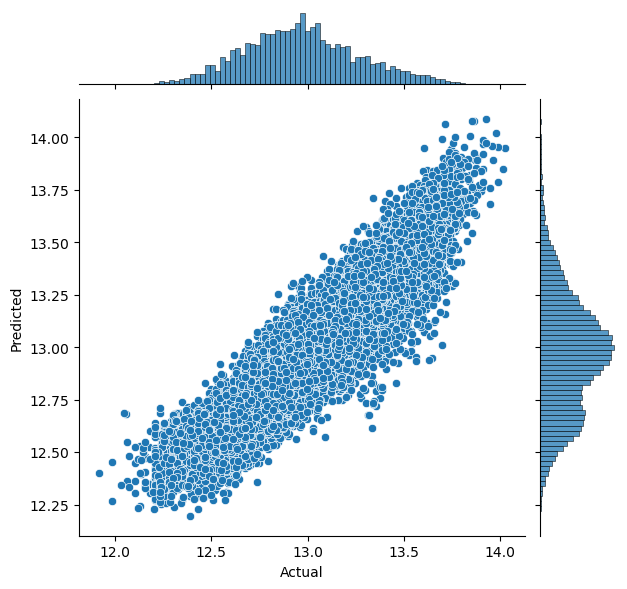

In [40]:
# lets look at the performance of the base model
y_pred_ridge = ridge.predict(X_test_ss)
sns.jointplot(x=y_test, y=y_pred_ridge)
plt.ylabel('Predicted')
plt.xlabel('Actual')

In [41]:
ridge.coef_

array([-0.02048985,  0.2068952 ,  0.01374265, -0.0437539 , -0.00619318,
        0.04946071, -0.01374265,  0.06526956, -0.00489188,  0.00031974,
       -0.00211035,  0.00246356, -0.00425204, -0.01122486, -0.04973797,
       -0.04349712,  0.0031924 ,  0.01119002, -0.00367655,  0.00625482,
        0.01374265, -0.06959009, -0.13917587, -0.07874737, -0.1178252 ,
        0.00518997,  0.00239707,  0.01364226, -0.00241213,  0.00443   ,
        0.00505905,  0.02415208,  0.00376495,  0.00055131,  0.02524403,
        0.00769047,  0.0071505 ,  0.00895924])

<AxesSubplot: >

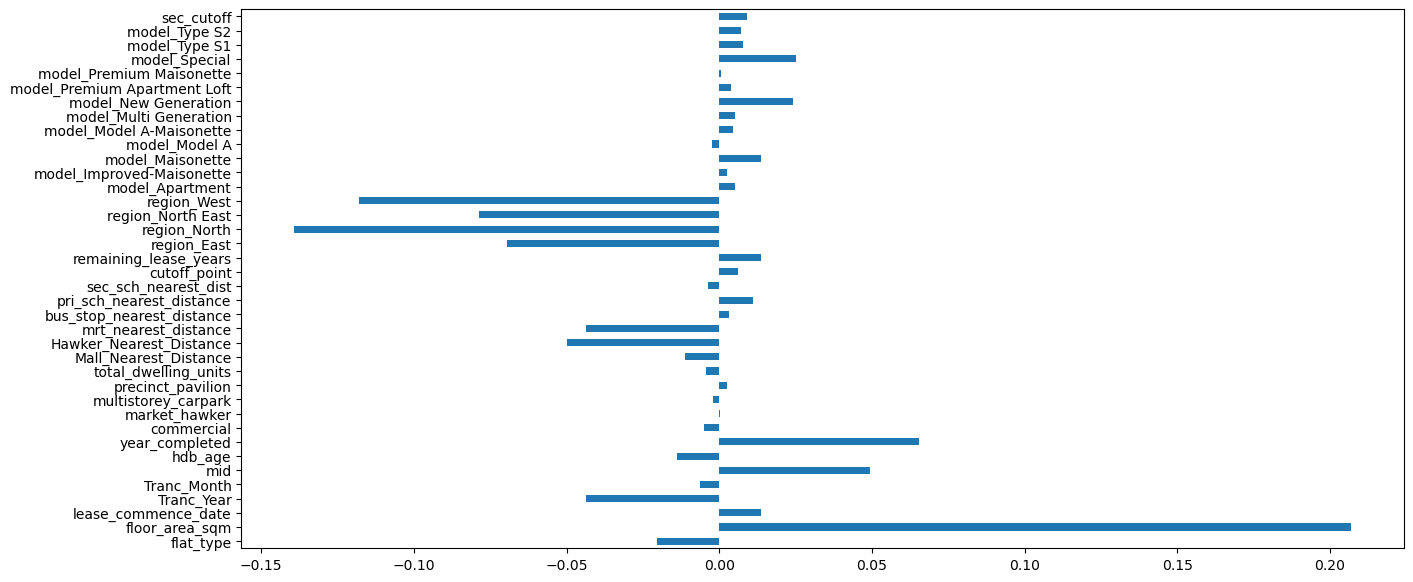

In [42]:
features = [col for col in df._get_numeric_data().columns if col != 'resale_price']
pd.Series(ridge.coef_, index=features).plot.barh(figsize=(15, 7))

It looks like some of the featues such as market_hawker, multistorey_carpark, model_Premium Maisonette are the coefficients close to zero. I will remove these features before training the model again

## Model Tuning
- to decrease noise of the model, and remove multicollinearity

In [43]:
df.head() # get the train data

flat_type  floor_area_sqm  lease_commence_date  resale_price  Tranc_Year  \
0          0            90.0                 2006     13.429848        2016   
1          1           130.0                 1987     13.407542        2012   
2          2           144.0                 1997     13.638773        2013   
3          0           103.0                 1992     13.217674        2012   
4          0            83.0                 1987     12.604849        2017   

   Tranc_Month  mid  hdb_age  year_completed  commercial  market_hawker  \
0            5   11       15            2005           0              0   
1            7    8       34            1987           0              0   
2            7   14       24            1996           0              0   
3            4    3       29            1990           1              0   
4           12    2       34            1987           0              0   

   multistorey_carpark  precinct_pavilion  total_dwelling_units  \
0                    0                  0                   142   
1                    0                  0                   112   
2                    0                  0                    90   
3                    0                  0                    75   
4                    0                  0                    48   

   Mall_Nearest_Distance  Hawker_Nearest_Distance  mrt_nearest_distance  \
0            1094.090418               154.753357            330.083069   
1             866.941448               640.151925            903.659703   
2            1459.579948              1762.082341           1334.251197   
3             950.175199               726.215262            907.453484   
4             729.771895              1540.151439            412.343032   

   bus_stop_nearest_distance  pri_sch_nearest_distance  sec_sch_nearest_dist  \
0                  29.427395               1138.633422           1138.633422   
1                  58.207761                415.607357            447.894399   
2                 214.747860                498.849039            180.074558   
3                  43.396521                389.515528            389.515528   
4                 129.422752                401.200584            312.025435   

   cutoff_point  remaining_lease_years  region_East  region_North  \
0           224                     83            0             0   
1           232                     64            0             0   
2           188                     74            0             0   
3           253                     69            0             0   
4           208                     64            0             1   

   region_North East  region_West  model_Apartment  model_Improved-Maisonette  \
0                  0            0                0                          0   
1                  0            0                0                          0   
2                  0            1                1                          0   
3                  0            0                0                          0   
4                  0            0                0                          0   

   model_Maisonette  model_Model A  model_Model A-Maisonette  \
0                 0              1                         0   
1                 0              0                         0   
2                 0              0                         0   
3                 0              1                         0   
4                 0              1                         0   

   model_Multi Generation  model_New Generation  model_Premium Apartment Loft  \
0                       0                     0                             0   
1                       0                     0                             0   
2                       0                     0                             0   
3                       0                     0                             0   
4                       0                     0   

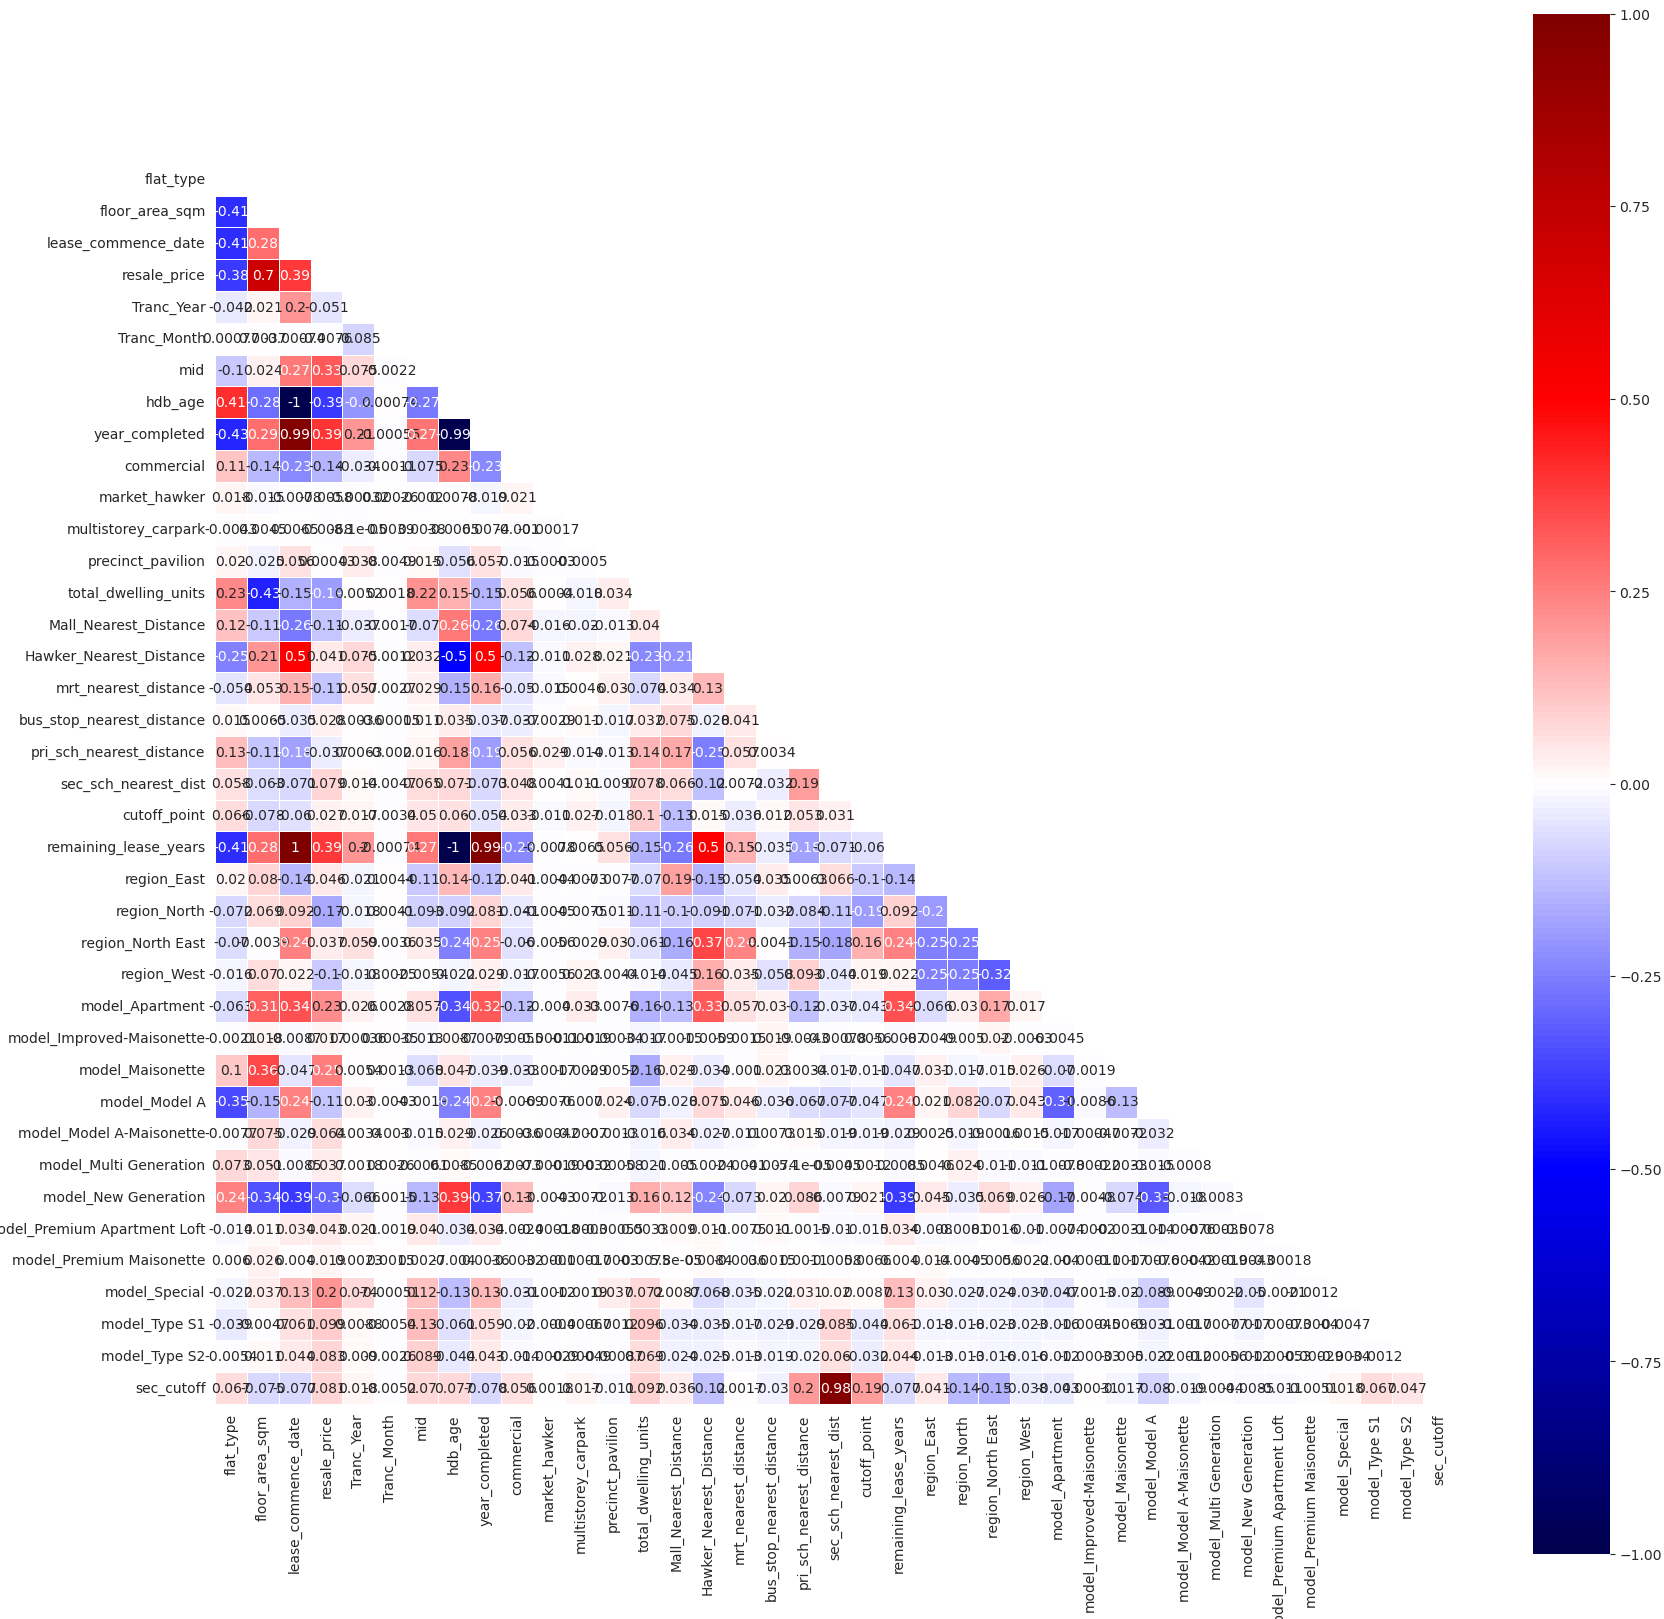

In [44]:
# check multicollinearity again
plt.figure(figsize = (20,20))

corr = df.corr()

# Set up mask to be "True" in the upper triangle. this is to reduce the number of 'squares' seen in the correlation heatmap
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Plot our correlation heatmap, while masking the upper triangle to be white.
with sns.axes_style("white"):
    sns.heatmap(corr, mask = mask, square = True, annot = True, vmin = -1, vmax = 1, linewidths = .5, cmap='seismic')

In [45]:
# drop the columns that are not important through feature importance 
df.drop(columns = ['market_hawker', 'market_hawker', 'multistorey_carpark', 'model_Premium Maisonette'], inplace=True)

In [46]:
df_pred.drop(columns = ['market_hawker', 'market_hawker', 'multistorey_carpark', 'model_Premium Maisonette'], inplace=True)

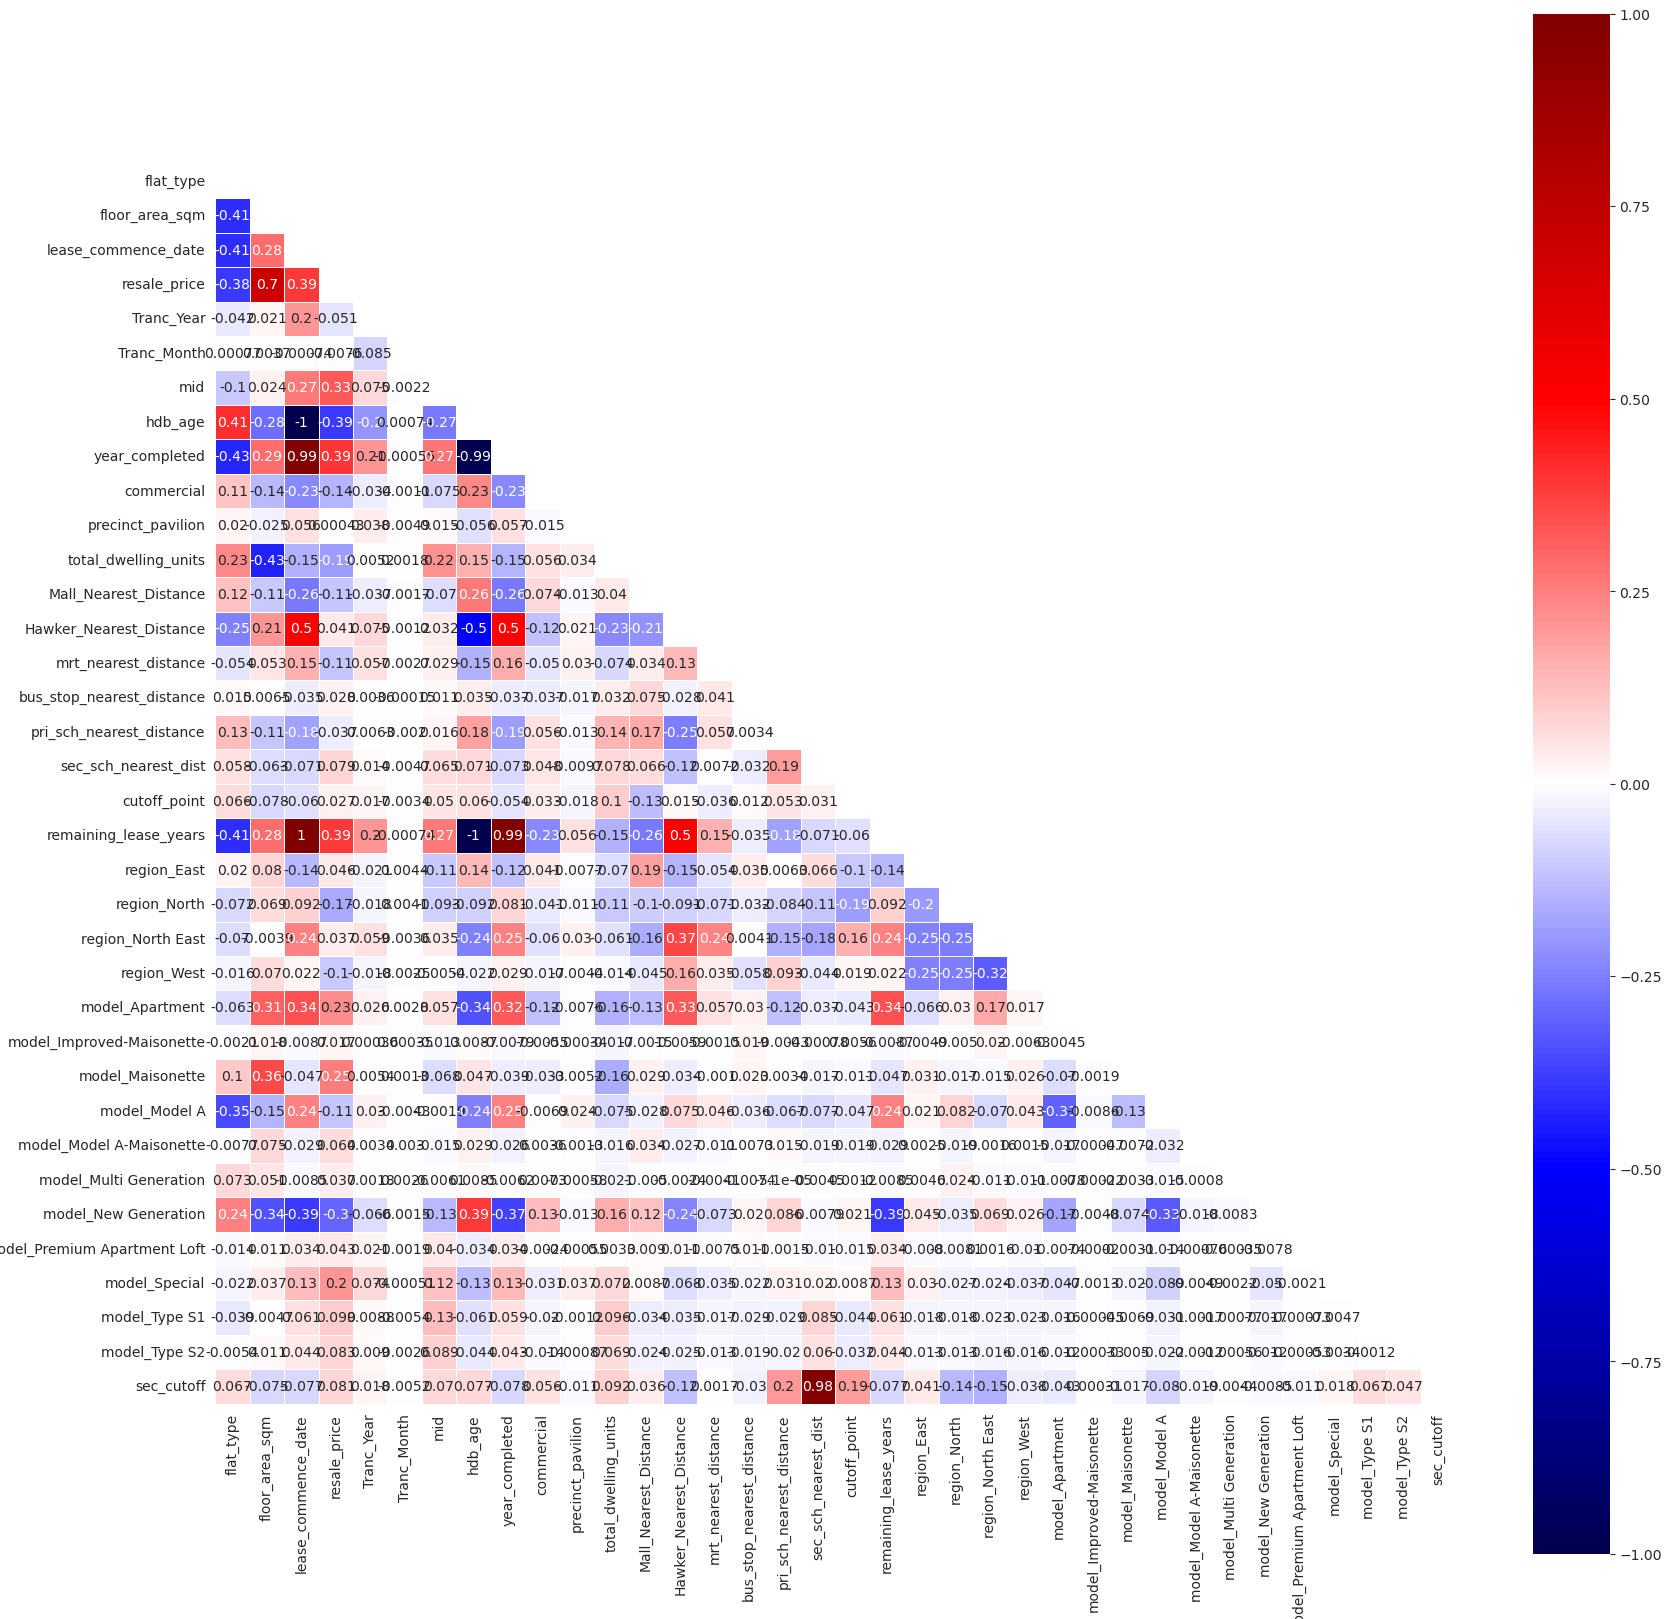

In [47]:
# check multicollinearity again

plt.figure(figsize = (20,20))

corr = df.corr()

# Set up mask to be "True" in the upper triangle. this is to reduce the number of 'squares' seen in the correlation heatmap
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Plot our correlation heatmap, while masking the upper triangle to be white.
with sns.axes_style("white"):
    sns.heatmap(corr, mask = mask, square = True, annot = True, vmin = -1, vmax = 1, linewidths = .5, cmap='seismic')

In [48]:
# drop remaining_lease_years as it has multicollinearity with 2 variables, and its not significant
# prioritize sec_cutoff, drop sec_nearest_distance due to feature significance and multicollinearity 
# hdb_age and lease_commence_date has a perfect collinearity. Both have similar significance; but we should drop it
df.drop(columns = ['remaining_lease_years', 'sec_sch_nearest_dist', 'hdb_age', 'lease_commence_date'], inplace=True)

In [49]:
df_pred.drop(columns = ['remaining_lease_years', 'sec_sch_nearest_dist', 'hdb_age', 'lease_commence_date'], inplace=True)

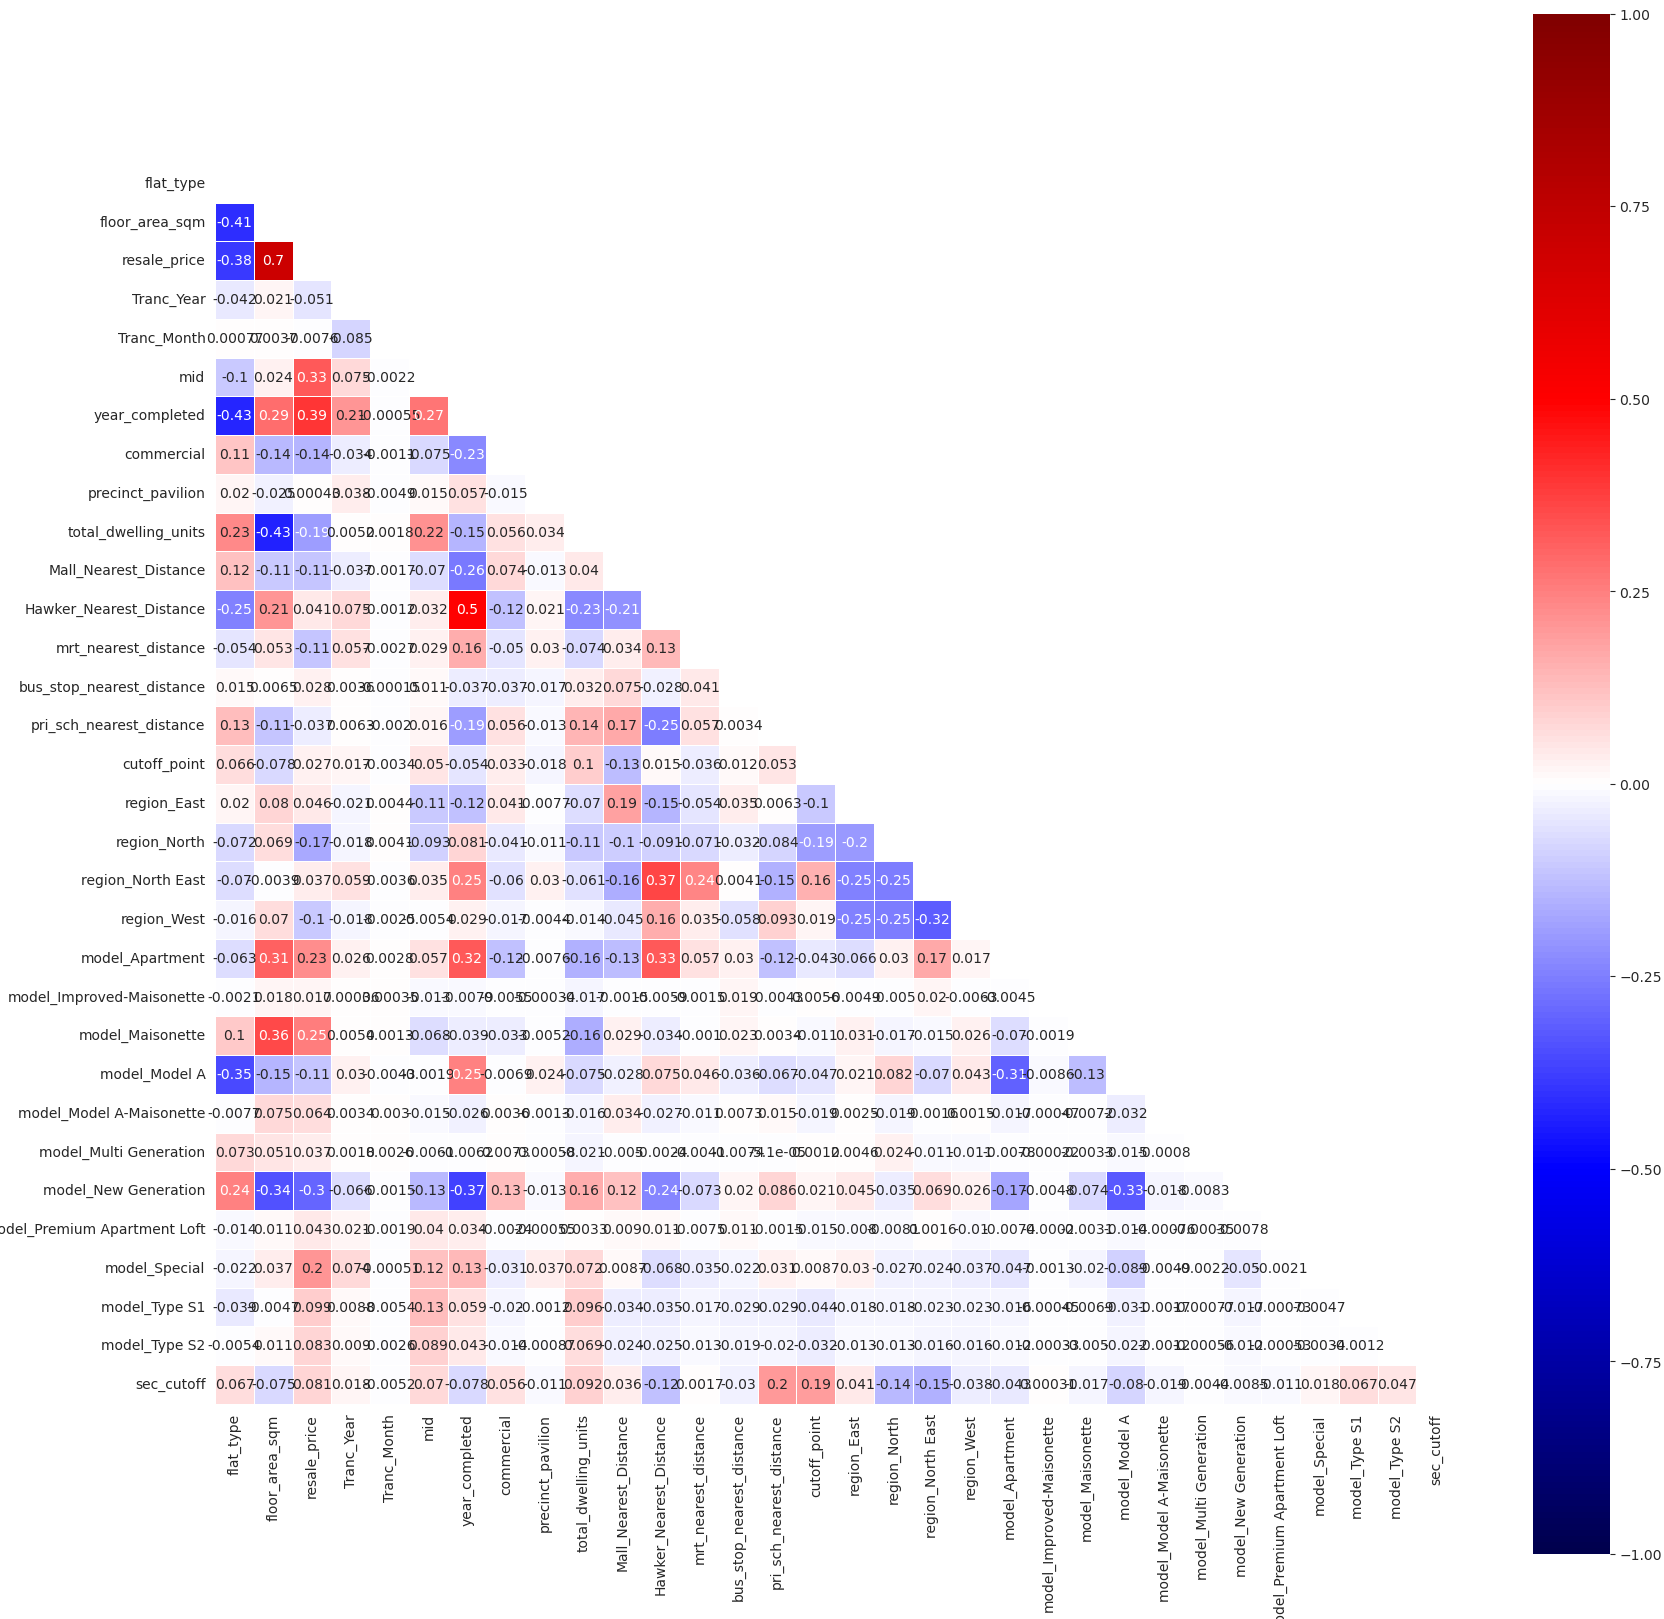

In [50]:
# check collinearity again
plt.figure(figsize = (20,20))

corr = df.corr()

# Set up mask to be "True" in the upper triangle. this is to reduce the number of 'squares' seen in the correlation heatmap
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Plot our correlation heatmap, while masking the upper triangle to be white.
with sns.axes_style("white"):
    sns.heatmap(corr, mask = mask, square = True, annot = True, vmin = -1, vmax = 1, linewidths = .5, cmap='seismic')

In [51]:
# not a lot of variables that are co-related now; we can try another round of ridge regression

## Run Production Model with refined features
In this section, we are going to use the Ridge regression model on the new set of features

In [133]:
# set up X and y variables again:
X = df.drop(['resale_price'], axis = 'columns')
y = df['resale_price']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2, # use 80/20 split, similar to the previous models
                                                    random_state = 42)

In [53]:
# do standard scaling on the new set of features
ss = StandardScaler()

# we will use fit_transform on X_train
# use transform on X_test
X_train_ss2 = ss.fit_transform(X_train)
X_test_ss2 = ss.transform(X_test)

In [56]:
ridge_2.fit(X_train_ss2, y_train)

Ridge(alpha=7.149428986597579)

In [54]:
# initialize the second ridge regression
ridge_2 = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores_2 = cross_val_score(ridge_2, X_train_ss2, y_train, cv=10)

print (ridge_scores)
print (np.mean(ridge_scores))

[0.83462716 0.83846013 0.84069872 0.84029691 0.8381237  0.83882803
 0.84350419 0.8426266  0.83999384 0.84004006]
0.8397199339857335


**Observation**: The model improved 0.0004 in terms of r2 score as compared to the best model in the last round. This means there's a higher amount of train data being able to be explained by the model. We can proceed to fit this into the validation set

## Model Evaluation: Production model (on train data)

In [140]:
# lets look at the performance of the ridge regression model

# run predictions on validation set
y_val_ridge_2 = ridge_2.predict(X_test_ss2)

In [ ]:
# evaluating the ridge_2 regression
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_val_ridge_2))
r2 = r2_score(y_test, y_val_ridge_2)
print("Root Mean Squared Error for refined Ridge regression:", rmse_ridge)
print("R-Squared for refined Ridge regression:", r2)

Root Mean Squared Error for refined Ridge regression: 0.12123973707935588
R-Squared for refined Ridge regression: 0.838978552987578


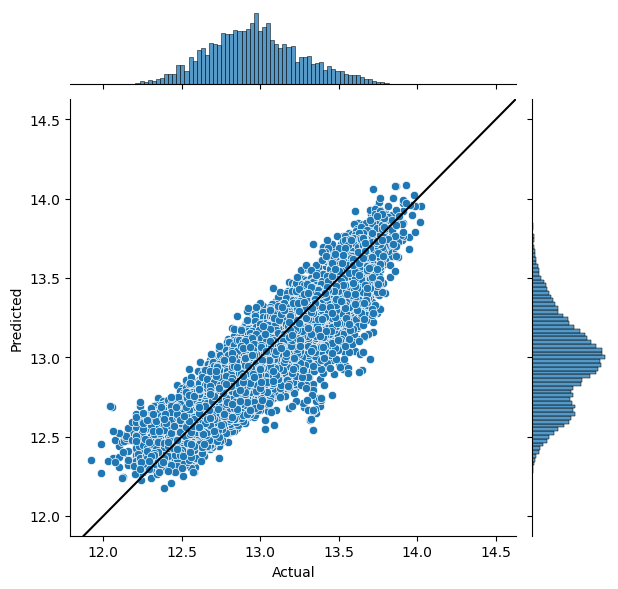

In [141]:
# plot the results from the prediction on validation set against true values in the validation set
sns.jointplot(x=y_test, y=y_val_ridge_2)
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.axline((12,12),(14.5,14.5),color='black')

**Observation**: 
1. RMSE values are lower than previous (0.1212 vs 0.12107457104727366), with a higher r2 score (0.83897 vs 0.8394169762080177).
2. Actual vs Prediction values seems to hover around a y=x line.
   - This looks quite promising, as it means prediction values are quite close to the actual values. 
   - However, we need to see the distribution of errors to make sure the model do not have any features which has collinearity.

In [ ]:
# actual - prediction
residuals = y_test - y_val_ridge_2

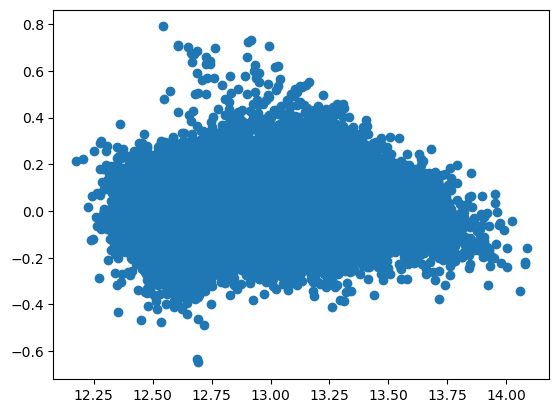

In [ ]:
plt.scatter(y_val_ridge_2, residuals)

The residuals do not fan out. This means it meets the homoscedastic error structure. This is desirable because it suggests that the variance of the errors is consistent and that the model's assumptions of equal variances across the range of the predictor variable are satisfied.

## Model Evaluation: Base Model

In [116]:
# base model predictions
mean_y = np.mean(df['resale_price'])

In [121]:
# get the rmse of the residuals

pred_base = np.array([mean_y for i in range(len(df['resale_price']))])
residuals_base_model = y - pred_base # use the whole df
squared_residuals = residuals_base_model ** 2
mean_squared_residuals = np.mean(squared_residuals)
rmse_base_model = np.sqrt(mean_squared_residuals)

print (f'RMSE for base model is: {rmse_base_model}')

RMSE for base model is: 0.30215097516294764


In [107]:
# calculate the residuals of the base model
residuals_base_model = y_test - np.mean(df['resale_price'])

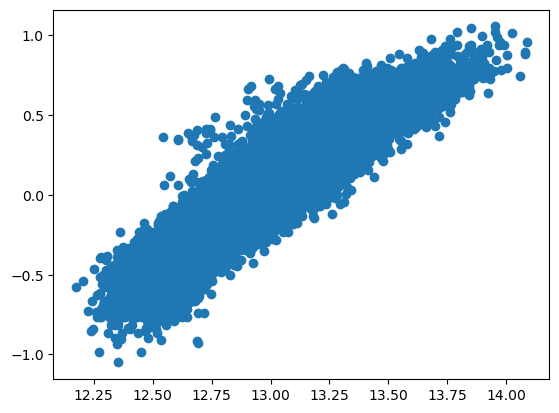

In [108]:
plt.scatter(y_val_ridge_2, residuals_base_model)

**Observations**: There is significant improvements with the chosen model (Ridge regression) against the base model 
1. Residuals: 
   - Base model: The residuals seems to have a linear relationship, which suggests heteroscedasticity
   - Chosen model: The residuals appear random and do not fan out


2. RMSE score :
   - Base model: 0.30215097516294764 
   - Chosen model: 0.12123973707935588, which is lower than the base model

## Production Model (for Kaggle Submission)
With the evaluation above, I will fit the improved Ridge regression as a prodiction mode into the test dataset

In [63]:
# define the list of features without id
features = ['flat_type', 'floor_area_sqm', 'Tranc_Year', 'Tranc_Month', 'mid',
       'year_completed', 'commercial', 'precinct_pavilion',
       'total_dwelling_units', 'Mall_Nearest_Distance',
       'Hawker_Nearest_Distance', 'mrt_nearest_distance',
       'bus_stop_nearest_distance', 'pri_sch_nearest_distance', 'cutoff_point',
       'region_East', 'region_North', 'region_North East', 'region_West',
       'model_Apartment', 'model_Improved-Maisonette', 'model_Maisonette',
       'model_Model A', 'model_Model A-Maisonette', 'model_Multi Generation',
       'model_New Generation', 'model_Premium Apartment Loft', 'model_Special',
       'model_Type S1', 'model_Type S2', 'sec_cutoff']

In [69]:
# set X variables
X_prod = df_pred[features]

In [134]:
X_prod.shape

(16737, 31)

In [94]:
X_prod = ss.transform(df_pred[features])

In [95]:
y_pred_ridge_2 = ridge_2.predict(df_pred[features]) 

/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


In [136]:
y_pred_ridge_2.shape

(16737,)

In [137]:
df_pred.head()

id  flat_type  floor_area_sqm  Tranc_Year  Tranc_Month  mid  \
0  114982          0            84.0        2012           11    8   
1   95653          1           112.0        2019            8    5   
2   40303          3            68.0        2013           10    8   
3  109506          0            97.0        2017           10    2   
4  100149          0           103.0        2016            8   17   

   year_completed  commercial  precinct_pavilion  total_dwelling_units  \
0            1986           1                  0                   132   
1            2002           0                  0                    53   
2            1979           0                  0                   218   
3            1976           0                  0                   104   
4            1985           0                  0                   144   

   Mall_Nearest_Distance  Hawker_Nearest_Distance  mrt_nearest_distance  \
0             877.431572               687.576779            686.660434   
1             534.037705              2122.346226            169.478175   
2             817.050453               152.287621            694.220448   
3            1272.737194               501.892158           1117.203587   
4            1070.963675               437.593564            987.976010   

   bus_stop_nearest_distance  pri_sch_nearest_distance  cutoff_point  \
0                  75.683952                426.467910           218   
1                  88.993058                439.756851           199   
2                  86.303575                355.882207           245   
3                 108.459039                929.744711           188   
4                 113.645431                309.926934           223   

   region_East  region_North  region_North East  region_West  model_Apartment  \
0            0             1                  0            0                0   
1            0             0                  0            1                1   
2            0             0                  1            0                0   
3            0             1                  0            0                0   
4            0             0                  0            1                0   

   model_Improved-Maisonette  model_Maisonette  model_Model A  \
0                          0                 0              1   
1                          0                 0              0   
2                          0                 0              0   
3                          0                 0              0   
4                          0                 0              1   

   model_Model A-Maisonette  model_Multi Generation  model_New Generation  \
0                         0                       0                     0   
1                         0                       0                     0   
2                         0                       0                     1   
3                         0                       0                     1   
4                         0                       0                     0   

   model_Premium Apartment Loft  model_Special  model_Type S1  model_Type S2  \
0                             0              0              0              0   
1                             0              0              0              0   
2                             0              0              0              0   
3                             0              0              0              0   
4                             0              0              0              0   

      sec_cutoff   Predicted  
0   34078.273019  258.443991  
1  147134.965932  799.638702  
2   74742.441795  488.013267  
3   81489.463089  493.762746  
4   48456.865525  331.794015

In [98]:
df_pred['Predicted'] = y_pred_ridge_2

In [99]:
kaggle_df = df_pred[['id','Predicted']]

In [100]:
kaggle_df.to_csv('./datasets/submission_hdb.csv',index=False)

In [101]:
kaggle_df.head()

id   Predicted
0  114982  258.443991
1   95653  799.638702
2   40303  488.013267
3  109506  493.762746
4  100149  331.794015

## Future enhancements and recommendation
The HDB resale price prediction model can be further trained by grouping/controlling features that matter

1. Group by number of rooms 
    - A 4R HDB flat has the most demand. 
    - In fact, most of the outliers lies with the 4R, 5R, and Executive HDB flats (https://www.propertyguru.com.sg/property-guides/million-dollar-4-room-flats-72832)
    - By controlling the number of rooms, we can train better models with specific features for a 4R-HDB flats

2. Group by regions
    - At first glance, AMK seems to be an undervalued town
    - There is a possibility that the area has older flats; hdb_age is one of the more important features in predicting resale_prices
    - We can do an EDA to find out more

3. Group by HDB Age